<a href="https://colab.research.google.com/github/8persy/algoritms_colab/blob/main/%22Backtracking_11_311_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Бэктрекинг

Переборный алгоритм, рассматривающий решение задачи как некоторый путь в дереве решений задачи

Рассмотрим что это и как оно работает на примере задачи поиска выхода из лабиринта

## Подготовка

[Файлы для тетрадки](https://drive.google.com/drive/folders/1gLVZqbkyfRtSKZsmYFqyTH1lZNPVPywV?usp=sharing)

В гугл-диске лежат 3 файла:
- maze.obj
  - Сгенерированный лабиринт (см. ДЗ-2), сжатый через pickle
- draw.obj
  - Функция отрисовки лабиринта, сжатый через dill (модификация pickle для функций)
- temp.mp4
  - Видео с демонстрацией работы алгоритма поиска выхода из лабиринта

Зададим класс ячейки лабиринта (понадобится попозже)

In [ ]:
from dataclasses import dataclass, field

@dataclass
class MazeCell:
    x: int
    y: int
    component: int
    is_open: bool = field(default=False)
    walls: list = field(default_factory=list)

Извлечем лабиринт из pickle

In [ ]:
import pickle

maze_file = open("maze.obj", "rb")

maze = pickle.load(maze_file)

maze

[[MazeCell(x=0, y=0, component=0, is_open=True, walls=[False, True, False, True]),
  MazeCell(x=1, y=0, component=1, is_open=False, walls=[True, True, False, True]),
  MazeCell(x=2, y=0, component=2, is_open=False, walls=[True, True, False, True]),
  MazeCell(x=3, y=0, component=3, is_open=False, walls=[True, False, False, True]),
  MazeCell(x=4, y=0, component=4, is_open=False, walls=[True, True, True, False]),
  MazeCell(x=5, y=0, component=5, is_open=False, walls=[True, False, True, True]),
  MazeCell(x=6, y=0, component=6, is_open=False, walls=[True, True, False, False]),
  MazeCell(x=7, y=0, component=7, is_open=False, walls=[True, False, False, True]),
  MazeCell(x=8, y=0, component=8, is_open=False, walls=[True, True, True, False]),
  MazeCell(x=9, y=0, component=9, is_open=False, walls=[True, True, False, True])],
 [MazeCell(x=0, y=1, component=10, is_open=False, walls=[False, False, True, True]),
  MazeCell(x=1, y=1, component=11, is_open=False, walls=[False, False, True, Fals

Извлечем функцию отрисовки из dill

In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
import dill

file = open("draw.obj", "rb")

N = len(maze)
LINE_WIDTH = 50
draw_maze = dill.load(file)

Отрисуем наш лабиринт

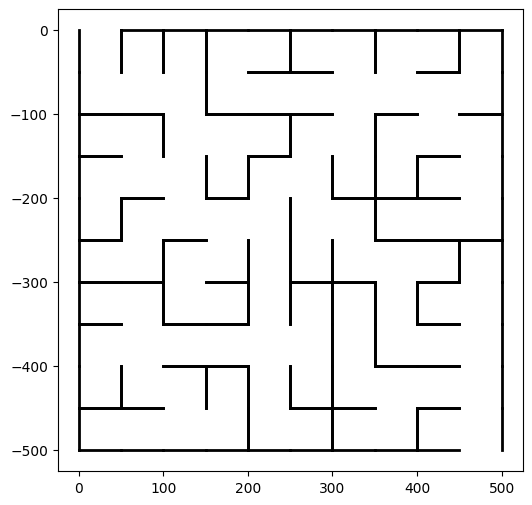

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))

draw_maze(maze)

plt.show()

## Задача

Реализовать функцию, ищущую путь от входа в лабиринт (в левом верхнем углу) к его выходу (в правом нижнем углу)

На выходе ожидаем массив направлений, в котором необходимо двигаться от входа к выходу

Направление - число от 0 до 3 включительно, начиная сверху по часовой стрелке
- 0 - вверх
- 1 - вправо
- 2 - вниз
- 3 - влево

Например, массив [2, 1, 1, 2] будет означать что для того чтобы выйти нам нужно пройти одну клетку вниз, затем 2 клетки вправа и в конце еще одну клетку вниз

## Подход к решению

Будем перебирать все варианты от входа к выходу

Представим дерево всех решений задачи

Полезная информация в ячейке - некоторая ячейка лабиринта

Корень дерева - вход лабиринта

Дети ячейки - те ячейки лабиринта, в которые можем попасть из исходной ячейки при условии перехода м-ду ячейками (если м-ду ячейками нет стен)

Рассмотрим как выглядит это дерево на примере сегмента лабиринта 3x3 в левом верхнем углу

Для простоты в ячейках будем писать координаты ячеек, а не сами ячейки

Ребра дерева - направления в которых мы передвигаемся

<img src="https://drive.google.com/uc?export=view&id=1fIoLiPxgLARH4Gm-Q2OQvQlDxgHfMPO5" height="200"/>

<img src="https://drive.google.com/uc?export=view&id=11xh-Zzae3_HVCw4OnloWQnnY7rG7nj49" height="600"/>

Если бы мы искали путь от 0,0 до 2,2 ответ был бы [2, 1, 1, 2]

Заметим что в дереве есть тупиковые листья

Тупиковый лист - лист, из ячейки которого нельзя выйти никуда, кроме как по направлению, откуда в эту ячейку пришли

Такими тупиковыми ячейками являются ячейки (0,1) и (0,2); Везде стены кроме как снизу


Как найти путь до некоторой ячейки по этому дереву?

- Для каждой ячейки будем переходить во все соседние ячейки (за исключением той, откуда пришли в эту ячейку)
- Если мы в тупике, будем возвращать None выше по дереву
- Если все ячейки поддерева тупиковые - возвращаем None и больше в это поддерево не возвращаемся
- Как только мы дошли до нужной нам ячейки (до выхода) - возвращаем путь к этой ячейке

Это и есть подход бэктрекинга

- Определяем что есть нода дерева
- Определяем что есть переход от ноды к детям
- Для каждого листа (в нашем случае лист == тупик), определяем удовлетворяет ли лист искомым условиям (является ли тупик выходом)
- Если все листы поддерева нас не устраивают, забрасываем это поддерево и перебираем другие поддеревья до тех пор, пока не найдем необходимое решение

Будем перебирать поддеревья в порядке, аналогичном порядку направлений (по часовой стрелке, начиная сверху); Перебираем сначала все варианты если идем наверх, затем если пойдем вправа и т.д.

Для визуализации есть небольшой видосик работы этого алгоритма

In [ ]:
import moviepy.editor
moviepy.editor.ipython_display("__temp__.mp4")

## Решение

Определим функцию бэктрекинга

Принимаем:
- Ячейку лабиирнта, для которой производим перебор
- Направление, откуда пришли в данную ячейку
- Путь по лабиринту, который прошли до данной ячейки

Возвращаем:
- Путь до ячейки (list из int), если в поддереве мы дошли до выхода (или если сама ячейка это выход)
- None, если ячейка/поддерево тупиковые

Для начала пропишем логику если мы оказались на выходе, возвращаем путь до ячейки

Если мы не на выходе, будем перебирать поддеревья для этой ячейки\
Перебираем стенки ячейки, если стены нет - перебираем варианты если мы заходим в ячейку за стенкой

Если во всех соседних ячейках только тупики - вернем None

Проверим, есть что нет стены и направление не равно направлению, откуда мы пришли

В зависимости от направления получаем соседние ячейки и вычисляем направление откуда пришли относительно новой ячейки (по сути просто меняем направление на противоположное)

Если идем вправо, направление 1\
Соттветственно, для новой ячейки направление откуда пришли равно 3

Для вычисления противоположного направления, прибавляем 2 и делим по модулю на 4
- 0 -> 2,
- 2 + 2 % 4 -> 0

Если нашлось поддерево без тупика - вернем его выше по дереву\
(а если не нашлось, то вернется None вне for, после перебора всех поддеревьев)

## Чекпоинт

In [ ]:
def backtracking(cell: MazeCell, prev_wall: int, path: list[int]) -> list[int] | None:
  pass

Инициализируем перебор входом лабиринта, укажем что пришли как бы сверху (тк для входа верхняя стена открыта) и укажем путь к корню

In [ ]:
result = backtracking(maze[0][0], 0, [])

result

[2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2]

Сделаем функцию отрисовки пути

<img src="https://www.meme-arsenal.com/memes/944f0328f6e3bb65a1c61bbbd2b0dc74.jpg" width="400px"/>

In [ ]:
def draw_path(path: list[int]):
  line_x = LINE_WIDTH // 2
  line_y = -LINE_WIDTH // 2

  for p in path:
    new_x = line_x
    new_y = line_y
    if p == 0:
      new_y += LINE_WIDTH
    elif p == 1:
      new_x += LINE_WIDTH
    elif p == 2:
      new_y -= LINE_WIDTH
    else:
      new_x -= LINE_WIDTH

    plt.plot([line_x, new_x], [line_y, new_y], color='red', lw=1)

    line_x = new_x
    line_y = new_y

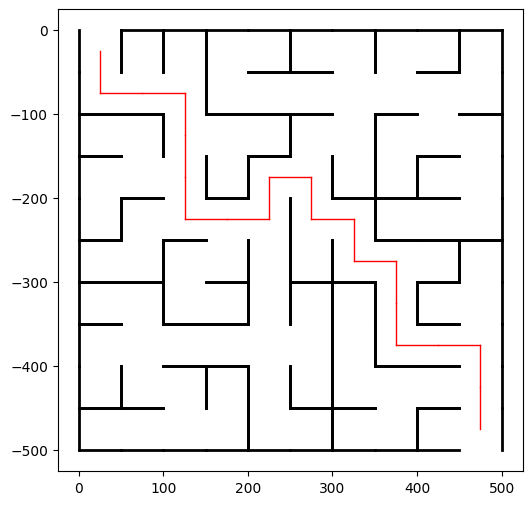

In [ ]:
fig = plt.figure(figsize=(6, 6))

draw_maze(maze)
draw_path(result)

plt.show()